In [1]:
import mwclient
import time
import transformers

site = mwclient.Site('en.wikipedia.org')
page = site.pages['Bitcoin']

In [2]:
revs = list(page.revisions())

In [3]:
revs[0]

OrderedDict([('revid', 1229590296),
             ('parentid', 1228816165),
             ('user', 'Vgbyp'),
             ('timestamp',
              time.struct_time(tm_year=2024, tm_mon=6, tm_mday=17, tm_hour=17, tm_min=3, tm_sec=36, tm_wday=0, tm_yday=169, tm_isdst=-1)),
             ('comment', 'version update')])

In [4]:
revs = sorted(revs, key=lambda rev: rev["timestamp"]) 

In [5]:
revs[0]

OrderedDict([('revid', 275832581),
             ('parentid', 0),
             ('user', 'Pratyeka'),
             ('timestamp',
              time.struct_time(tm_year=2009, tm_mon=3, tm_mday=8, tm_hour=16, tm_min=41, tm_sec=7, tm_wday=6, tm_yday=67, tm_isdst=-1)),
             ('comment', 'creation (stub)')])

In [6]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

def find_sentiment(text):
    sent = sentiment_pipeline([text[:250]])[0]
    score = sent["score"]
    if sent["label"] == "NEGATIVE":
        score *= -1
    return score

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\SUBRAT\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to forc

In [7]:
edits = {}
for rev in revs:        
    date = time.strftime("%Y-%m-%d", rev["timestamp"])
    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0)
    
    edits[date]["edit_count"] += 1
    
    comment = rev.get("comment", "")
    edits[date]["sentiments"].append(find_sentiment(comment))

In [8]:
from statistics import mean

for key in edits:
    if len(edits[key]["sentiments"]) > 0:
        edits[key]["sentiment"] = mean(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s < 0]) / len(edits[key]["sentiments"])
    else:
        edits[key]["sentiment"] = 0
        edits[key]["neg_sentiment"] = 0
    
    del edits[key]["sentiments"]

In [9]:
import pandas as pd
edits_df = pd.DataFrame.from_dict(edits, orient="index")

In [10]:
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.750000
2009-08-05,1,0.748121,0.000000
2009-08-06,2,0.995746,0.000000
2009-08-14,1,0.930021,0.000000
2009-10-13,2,-0.227500,0.500000
...,...,...,...
2024-05-22,9,-0.167402,0.555556
2024-05-24,1,-0.998527,1.000000
2024-05-26,1,-0.995705,1.000000
2024-06-13,1,0.990891,0.000000


In [11]:
rolling_edits = edits_df.rolling(30, min_periods=30).mean()
rolling_edits = rolling_edits.dropna()
rolling_edits

,edit_count,sentiment,neg_sentiment
2010-07-14,3.233333,0.249862,0.335852
2010-07-15,3.233333,0.238381,0.344185
2010-07-16,3.400000,0.245027,0.344185
2010-07-18,3.400000,0.205484,0.360852
2010-07-19,3.500000,0.203443,0.360852
...,...,...,...
2024-05-22,2.833333,-0.364329,0.678439
2024-05-24,2.800000,-0.400286,0.695106
2024-05-26,2.800000,-0.466192,0.728439
2024-06-13,2.800000,-0.465617,0.728439


In [12]:
rolling_edits.to_csv("bitcoin_sentiment.csv")

C:\Users\SUBRAT\AppData\Local\Temp\ipykernel_4496\2685336952.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_7_days_df = edits_df.last('7D')
C:\Users\SUBRAT\AppData\Local\Temp\ipykernel_4496\2685336952.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='Metric', y='Average Value', data=avg_values, palette='Set2')


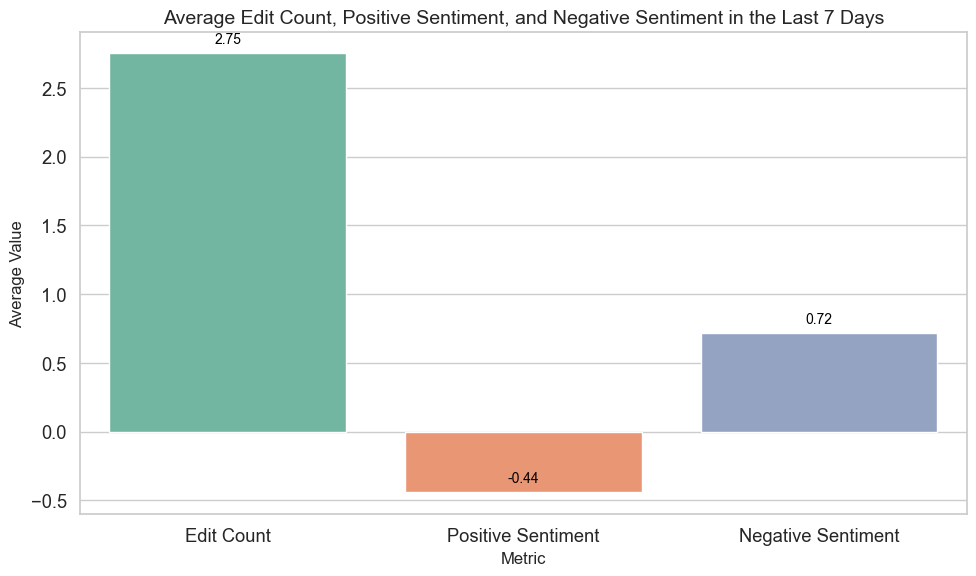

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV file into a DataFrame (replace 'bitcoin_sentiment.csv' with your actual file path)
edits_df = pd.read_csv('bitcoin_sentiment.csv', parse_dates=True, index_col=0)

# Filter data for the last 7 days
last_7_days_df = edits_df.last('7D')

# Calculate average values for last 7 days
avg_edit_count = last_7_days_df['edit_count'].mean()
avg_pos_sentiment = last_7_days_df['sentiment'].mean()
avg_neg_sentiment = last_7_days_df['neg_sentiment'].mean()

# Create a DataFrame for plotting
avg_values = pd.DataFrame({
    'Metric': ['Edit Count', 'Positive Sentiment', 'Negative Sentiment'],
    'Average Value': [avg_edit_count, avg_pos_sentiment, avg_neg_sentiment]
})

# Plotting using seaborn with enhanced aesthetics
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid', font_scale=1.2)  # Set style and font scale

# Plot bar graph
plot = sns.barplot(x='Metric', y='Average Value', data=avg_values, palette='Set2')

# Add data labels
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=10,  # Adjust font size of annotations
                  color='black')  # Set color of annotations

# Labels and title
plt.xlabel('Metric', fontsize=12)  # Adjust font size of x-label
plt.ylabel('Average Value', fontsize=12)  # Adjust font size of y-label
plt.title('Average Edit Count, Positive Sentiment, and Negative Sentiment in the Last 7 Days', fontsize=14)  # Adjust font size of title

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
